# Optimisation using apmv setpoints

In [1]:
#todo import qgrid to manually change output dfs

In [2]:
import accim
import accim.parametric_and_optimisation.funcs_for_besos.param_accis as bf
from accim.parametric_and_optimisation.objectives import average_results
from accim.parametric_and_optimisation.utils import make_all_combinations
from besos import eppy_funcs as ef
import matplotlib.pyplot as plt
import seaborn as sns
from accim.utils import print_available_outputs_mod, get_accim_args
from accim.parametric_and_optimisation.main import OptimParamSimulation, get_rdd_file_as_df, get_mdd_file_as_df, parse_mtd_file
from os import listdir


Let's have a look at the files we currently have in the path:

In [3]:
original_files = [i for i in listdir()]
original_files

['.ipynb_checkpoints',
 'optim_accim_custom_model.ipynb',
 'optim_apmv_setpoints.ipynb',
 'param_sim_accim_custom_model.ipynb',
 'param_sim_accim_predefined_model.ipynb',
 'param_sim_apmv_setpoint.ipynb',
 'Seville.epw',
 'Sydney.epw',
 'TestModel.idf',
 'TestModel_aPMV.idf',
 '__init__.py']

Firstly, the IDF must be read using besos's `get_building` function.

In [4]:
building = ef.get_building('TestModel_aPMV.idf')

For this analysis, we want to use the HVAC system in all hours of the year, so that temperature is always comfortable. Therefore, we are going to set the occupancy to always on by means of the function `accim.utils.set_occupancy_to_always`, in which we input the IDF class instance we read in the previous cell.

In [5]:
accim.utils.set_occupancy_to_always(idf_object=building)

On 24/7 Schedule:Compact object was already in the model.
People PlantaX08:Office Number of People Schedule Name has been set to always occupied.


Now, let's start with the settings for the parametric analysis. First, let's instantiate the class `OptimParamSimulation`, and let's pass the IDF instance in the argument `building`. Argument `parameters_type` can take 3 different strings:
- "accim predefined model", in which models are those previously defined in accim (ComfStand=0 to ComfStand=22);
- "accim custom model", in which key parameters of the adaptive comfort model are defined in the relevant arguments;
- "apmv setpoints", in which setpoints are based on the aPMV (Adaptive Predicted Mean Vote) instead of the PMV index;

In this case, we're going to use the 'apmv setpoints' type, in which we can define the adaptive comfort model.

In [6]:
parametric = OptimParamSimulation(
    building=building,
    parameters_type='apmv setpoints',
    #output_type='standard', #
    #output_keep_existing=False, #
    #output_freqs=['hourly'], #
    #ScriptType='vrf_mm', #
    #SupplyAirTempInputMethod='temperature difference', #
    #debugging=True, #
    #verbosemode=False #
)

PMV_H_SP_PlantaX08_Office Schedule has been added
PMV_C_SP_PlantaX08_Office Schedule has been added
Added - PMV_PlantaX08_Office Sensor
Added - People_Occupant_Count_PlantaX08_Office Sensor
Added - PMV_H_SP_act_PlantaX08_Office Actuator
Added - PMV_C_SP_act_PlantaX08_Office Actuator
Added - CoolingSeason GlobalVariable object
Added - CoolSeasonEnd GlobalVariable object
Added - CoolSeasonStart GlobalVariable object
Added - tolerance_cooling_sp_PlantaX08_Office GlobalVariable object
Added - tolerance_cooling_sp_cooling_season_PlantaX08_Office GlobalVariable object
Added - tolerance_cooling_sp_heating_season_PlantaX08_Office GlobalVariable object
Added - tolerance_heating_sp_PlantaX08_Office GlobalVariable object
Added - tolerance_heating_sp_cooling_season_PlantaX08_Office GlobalVariable object
Added - tolerance_heating_sp_heating_season_PlantaX08_Office GlobalVariable object
Added - adap_coeff_PlantaX08_Office GlobalVariable object
Added - adap_coeff_heating_PlantaX08_Office GlobalVariab

An initial and generic version of the Adaptive-Comfort-Control-Implementation Script (ACCIS) has been added to the idf instance `building`. For instance, you can take a look at the parameter values accis currently has:

In [7]:
[i for i in building.idfobjects['energymanagementsystem:program'] if 'set_zone_input_data' in i.Name.lower()]

[
 ENERGYMANAGEMENTSYSTEM:PROGRAM,
     set_zone_input_data_PlantaX08_Office,    !- Name
     set adap_coeff_cooling_PlantaX08_Office = 0.293,    !- Program Line 1
     set adap_coeff_heating_PlantaX08_Office = -0.293,    !- Program Line 2
     set pmv_cooling_sp_PlantaX08_Office = -0.5,    !- Program Line 3
     set pmv_heating_sp_PlantaX08_Office = 0.5,    !- Program Line 4
     set tolerance_cooling_sp_cooling_season_PlantaX08_Office = -0.1,    !- Program Line 5
     set tolerance_cooling_sp_heating_season_PlantaX08_Office = -0.1,    !- Program Line 6
     set tolerance_heating_sp_cooling_season_PlantaX08_Office = 0.1,    !- Program Line 7
     set tolerance_heating_sp_heating_season_PlantaX08_Office = 0.1;    !- Program Line 8]

## Setting the outputs

**If you have already read any of the other parametric simulation examples, you can skip this entire outputs section, since it is exactly the same.**

### Outputs for the idf (i.e. the outputs for each simulation run)

First of all, we are going to set the outputs of the simulations that are going to be performed. This is an important step, especially if you are going to run hundreds or thousands of simulations.

Let's take a look at the Output:Variable objects we currently have in the idf. The method `get_output_var_df_from_idf()` returns a pandas DataFrame which contains the information of the existing Output:Variable objects in the idf:

In [8]:
df_output_variables_idf = parametric.get_output_var_df_from_idf()
df_output_variables_idf

key_value  \
0                         People PlantaX08:Office   
1                         People PlantaX08:Office   
2                         People PlantaX08:Office   
3                         People PlantaX08:Office   
4                                               *   
5                                               *   
6                                               *   
7                                               *   
8                                               *   
9                                               *   
10                                              *   
11                                              *   
12                                              *   
13                                              *   
14                                              *   
15                                              *   
16                                              *   
17                                              *   
18                                              *   
19                                              *   
20                                              *   
21                                              *   
22                                              *   
23                                              *   
24                                              *   
25                                              *   
26                                              *   
27                                              *   
28                                              *   
29                                              *   
30                                              *   
31                                              *   
32                                              *   
33                                              *   
34                                              *   
35                                              *   
36                                              *   
37                                              *   
38                                              *   
39                                              *   
40                                              *   
41                                              *   
42                                              *   
43                      PMV_H_SP_PlantaX08_Office   
44                      PMV_C_SP_PlantaX08_Office   
45  Default Air Velocity for Comfort Calculations   

                                        variable_name frequency schedule_name  
0               Zone Thermal Comfort Fanger Model PMV    hourly       On 24/7  
1               Zone Thermal Comfort Fanger Model PPD    hourly       On 24/7  
2       Zone Thermal Comfort Mean Radiant Temperature    hourly       On 24/7  
3          Zone Thermal Comfort Operative Temperature    hourly       On 24/7  
4                Site Outdoor Air Drybulb Temperature    hourly                
5               Site Outdoor Air Dewpoint Temperature    hourly                
6                                     Site Wind Speed    hourly                
7                                 Site Wind Direction    hourly                
8           Site Direct Solar Radiation Rate per Area    hourly                
9          Site Diffuse Solar Radiation Rate per Area    hourly                
10                           Site Solar Azimuth Angle    hourly                
11                          Site Solar Altitude Angle    hourly                
12               Site Outdoor Air Barometric Pressure    hourly                
13              Adaptive Coefficient_PlantaX08_Office    Hourly                
14                              aPMV_PlantaX08_Office    Hourly                
15             aPMV Heating Setpoint_PlantaX08_Office    Hourly                
16             aPMV Cooling Setpoint_PlantaX08_Office    Hourly                
17  aPMV Heating Setpoint No Tolerance_PlantaX08_O...    Hourly                
18  aPMV Cooling Setpoint No

now, let's see the Output:Meter objects:

In [9]:
df_output_meters_idf = parametric.get_output_meter_df_from_idf()
df_output_meters_idf.head()

Empty DataFrame
Columns: [key_name, frequency]
Index: []

In this case, we can see there is no Output:Meter. However, there is a large number of Output:Variable objects which might result in heavy simulation outputs. So, let's get rid of some of them. We can drop the rows we want, and then input the modified DataFrame in the method `set_output_var_df_to_idf(outputs_df)`.

In [10]:
df_output_variables_idf = df_output_variables_idf[
        df_output_variables_idf['variable_name'].str.contains('aPMV')
]
df_output_variables_idf

key_value                                      variable_name frequency  \
14         *                              aPMV_PlantaX08_Office    Hourly   
15         *             aPMV Heating Setpoint_PlantaX08_Office    Hourly   
16         *             aPMV Cooling Setpoint_PlantaX08_Office    Hourly   
17         *  aPMV Heating Setpoint No Tolerance_PlantaX08_O...    Hourly   
18         *  aPMV Cooling Setpoint No Tolerance_PlantaX08_O...    Hourly   

   schedule_name  
14                
15                
16                
17                
18

Let's keep only the Output:Variable objects we have filtered using the `set_output_var_df_to_idf(outputs_df)`:

In [11]:
parametric.set_output_var_df_to_idf(outputs_df=df_output_variables_idf)

We have removed all rows except the adaptive heating and cooling setpoints, the operative temperature and the running mean outdoor temperature. Next optional step is adding Output:Meter objects. We can do that using the method `set_output_met_objects_to_idf(output_meters)`, where `output_meters` is a list of Output:Meter key names.

In [12]:
output_meters = [
    'Heating:Electricity',
    'Cooling:Electricity',
    #'Electricity:HVAC',
]
parametric.set_output_met_objects_to_idf(output_meters=output_meters)

Let's see Output:Meter objects we currently have after adding these:

In [13]:
df_output_meters_idf = parametric.get_output_meter_df_from_idf()
df_output_meters_idf.head()

key_name frequency
0  Heating:Electricity    hourly
1  Cooling:Electricity    hourly

### Outputs to be read and shown in the parametric simulation or optimisation

To successfully run the parametric simulation or optimisation, it is advisable running a test simulation to know the outputs that each simulation will have. We can do that with the method `get_outputs_df_from_testsim()`, which returns a tuple containing 2 DataFrames containing respectively the Output:Meter and Output:Variable objects from the simulation. In this case, you won't find wildcards such as "*".

In [14]:
df_output_meters_testsim, df_output_variables_testsim = parametric.get_outputs_df_from_testsim()

In [15]:
df_output_meters_testsim

key_name frequency
0  Heating:Electricity    Hourly
1  Cooling:Electricity    Hourly

In [16]:
df_output_variables_testsim

key_value                                      variable_name frequency
0       EMS                              aPMV_PlantaX08_Office    Hourly
1       EMS             aPMV Heating Setpoint_PlantaX08_Office    Hourly
2       EMS             aPMV Cooling Setpoint_PlantaX08_Office    Hourly
3       EMS  aPMV Heating Setpoint No Tolerance_PlantaX08_O...    Hourly
4       EMS  aPMV Cooling Setpoint No Tolerance_PlantaX08_O...    Hourly

We can get DataFrames from the .rdd and .mdd files generated from the test simulation using the functions `get_rdd_file_as_df()` and `get_mdd_file_as_df()`. 

In [17]:
df_rdd = get_rdd_file_as_df()
df_rdd

object key_value  \
0    Output:Variable         *   
1    Output:Variable         *   
2    Output:Variable         *   
3    Output:Variable         *   
4    Output:Variable         *   
..               ...       ...   
502  Output:Variable         *   
503  Output:Variable         *   
504  Output:Variable         *   
505  Output:Variable         *   
506  Output:Variable         *   

                                         variable_name frequency  \
0                 Site Outdoor Air Drybulb Temperature    hourly   
1                Site Outdoor Air Dewpoint Temperature    hourly   
2                 Site Outdoor Air Wetbulb Temperature    hourly   
3                      Site Outdoor Air Humidity Ratio    hourly   
4                   Site Outdoor Air Relative Humidity    hourly   
..                                                 ...       ...   
502  Zone Mechanical Ventilation Standard Density V...    hourly   
503  Zone Mechanical Ventilation Standard Density V...    hourly   
504  Zone Mechanical Ventilation Current Density Vo...    hourly   
505  Zone Mechanical Ventilation Current Density Vo...    hourly   
506   Zone Mechanical Ventilation Air Changes per Hour    hourly   

                                   units  
0                    !- Zone Average [C]  
1                    !- Zone Average [C]  
2                    !- Zone Average [C]  
3     !- Zone Average [kgWater/kgDryAir]  
4                    !- Zone Average [%]  
..                                   ...  
502               !- HVAC Average [m3/s]  
503                     !- HVAC Sum [m3]  
504               !- HVAC Average [m3/s]  
505                     !- HVAC Sum [m3]  
506                !- HVAC Average [ach]  

[507 rows x 5 columns]

In [18]:
df_mdd = get_mdd_file_as_df()
df_mdd

object                                   meter_name  \
0              Output:Meter                         Electricity:Facility   
1   Output:Meter:Cumulative                         Electricity:Facility   
2              Output:Meter                         Electricity:Building   
3   Output:Meter:Cumulative                         Electricity:Building   
4              Output:Meter            Electricity:Zone:PLANTAX08:OFFICE   
..                      ...                                          ...   
73  Output:Meter:Cumulative                  General:Heating:Electricity   
74             Output:Meter                   Carbon Equivalent:Facility   
75  Output:Meter:Cumulative                   Carbon Equivalent:Facility   
76             Output:Meter  CarbonEquivalentEmissions:Carbon Equivalent   
77  Output:Meter:Cumulative  CarbonEquivalentEmissions:Carbon Equivalent   

   frequency     units  
0     hourly    !- [J]  
1     hourly    !- [J]  
2     hourly    !- [J]  
3     hourly    !- [J]  
4     hourly    !- [J]  
..       ...       ...  
73    hourly    !- [J]  
74    hourly   !- [kg]  
75    hourly   !- [kg]  
76    hourly   !- [kg]  
77    hourly   !- [kg]  

[78 rows x 4 columns]

Also, we can parse the .mtd files as a list using the function `parse_mtd_file()`.

In [19]:
mtd_list = parse_mtd_file()
mtd_list[0:2]

[{'meter_id': '8',
  'description': 'PLANTAX08:OFFICE GENERAL LIGHTING:Lights Electricity Energy [J]',
  'on_meters': ['Electricity:Facility [J]',
   'Electricity:Building [J]',
   'Electricity:Zone:PLANTAX08:OFFICE [J]',
   'InteriorLights:Electricity [J]',
   'InteriorLights:Electricity:Zone:PLANTAX08:OFFICE [J]',
   'ELECTRIC EQUIPMENT#PlantaX08:Office#GeneralLights:InteriorLights:Electricity [J]']},
 {'meter_id': '92',
  'description': 'PLANTAX08:OFFICE:Zone Air System Sensible Heating Energy [J]',
  'on_meters': ['EnergyTransfer:Facility [J]',
   'EnergyTransfer:Building [J]',
   'EnergyTransfer:Zone:PLANTAX08:OFFICE [J]',
   'Heating:EnergyTransfer [J]',
   'Heating:EnergyTransfer:Zone:PLANTAX08:OFFICE [J]',
   'General:Heating:EnergyTransfer [J]']}]

Therefore, we have 2 DataFrames, one for the Output:Meter and another for the Output:Variable objects. Next step is setting the outputs for the parametric simulation. To do so, we'll need to pass the DataFrames into the method `set_outputs_for_simulation(df_output_meter, df_output_variable)`. If you have some knowledge about the python package besos, you might think of these dataframes as if each row was a `MeterReader` or `VariableReader` instances respectively for the Output:Meter and Output:Variable dataframes, and the arguments in these were the specified in the columns. The `MeterReader` class takes the arguments `key_name`, `frequency`, `name` and `func`, while `VariableReader` class takes the arguments  `key_value`, `variable_name`, `frequency`, `name` and `func`.

In [20]:
[i for i in df_output_meters_testsim.columns]

['key_name', 'frequency']

In [21]:
[i for i in df_output_variables_testsim.columns]

['key_value', 'variable_name', 'frequency']

If you take a look at the columns of the dataframes above, you can see the names are the arguments in the `MeterReader` and `VariableReader` classes, and only `name` and `func` are missing. That means, you can add these columns to input the `name` and `func` arguments as desired. **The only limitation is that you cannot return time series in optimisation**. In case of the Output:Meter dataframe, we won't add the `name` and `func` columns, which means the name will be the `key_name` and hourly results will be aggregated using the pd.Series.sum() function. However, in case of the Output:Variable dataframe, we will specify these: we want the average rather than the sum, therefore we will pass the name bound to the function `average_results`, and we will add '_average' as a suffix to the `variable_name` column. We will also remove the outputs for BLOCK1:ZONE2, which are the rows 2 and 4.

In [22]:
df_output_variables_testsim['func'] = average_results
df_output_variables_testsim['name'] = df_output_variables_testsim['variable_name'] + '_average'
df_output_variables_testsim = df_output_variables_testsim.drop(index=[2, 4])
df_output_variables_testsim

key_value                                      variable_name frequency  \
0       EMS                              aPMV_PlantaX08_Office    Hourly   
1       EMS             aPMV Heating Setpoint_PlantaX08_Office    Hourly   
3       EMS  aPMV Heating Setpoint No Tolerance_PlantaX08_O...    Hourly   

                                               func  \
0  <function average_results at 0x000002A8476F4C10>   
1  <function average_results at 0x000002A8476F4C10>   
3  <function average_results at 0x000002A8476F4C10>   

                                                name  
0                      aPMV_PlantaX08_Office_average  
1     aPMV Heating Setpoint_PlantaX08_Office_average  
3  aPMV Heating Setpoint No Tolerance_PlantaX08_O...

Finally, let's set the outputs for parametric simulation and optimisation:

In [23]:
parametric.set_outputs_for_simulation(
    df_output_meter=df_output_meters_testsim,
    #df_output_variable=df_output_variables_testsim,
)

If you want to inspect the `VariableReader` and `MeterReader` objects, you can see the internal variable `sim_outputs`:

In [24]:
parametric.sim_outputs

[MeterReader(name='Heating:Electricity', class_name='Output:Meter', frequency='Hourly', func=<function sum_values at 0x000002A8485E4310>, key_name='Heating:Electricity'),
 MeterReader(name='Cooling:Electricity', class_name='Output:Meter', frequency='Hourly', func=<function sum_values at 0x000002A8485E4310>, key_name='Cooling:Electricity')]

## Setting the parameters

At the top of the script, when you instantiated the class `OptimParamSimulation`, you already specified which type of parameters you were going to use. Now, the parameters we're about to set, must match the `parameters_type` argument. At this point, you may not know which parameters you can use, so you can call the method `get_available_parameters()`, which will return a list of available parameters:

In [25]:
available_parameters = parametric.get_available_parameters()
available_parameters

['Adaptive coefficient',
 'Adaptive cooling coefficient',
 'Adaptive heating coefficient',
 'PMV setpoint',
 'PMV cooling setpoint',
 'PMV heating setpoint']

If you don't know what are these, please refer to the [documentation](https://accim.readthedocs.io/en/master/4_detailed%20use.html).

Using the 'apmv setpoints' type, the values can be either a list of options or a range of values. Now, let's set the parameters using the method `set_parameters(accis_params_dict, additional_params)`. In this method, we set the parameters related to accim using the argument `accis_params_dict`, which takes a dictionary following the pattern {'parameter name': [1, 2, 3, etc]} in case of list of options, or {'parameter name': (min_value, max_value)} in case of the range of values. We can also add some other parameters not related to accim in the argument `additional_params`, which takes a list of parameters as if these were input straight to the besos EPProblem class.

An example using ranges, could be:

In [26]:
accis_parameters = {
    'Adaptive coefficient': (0.01, 0.99),
    'PMV setpoint': (0.2, 0.7),
}
parametric.set_parameters(accis_params_dict=accis_parameters)

C:\Users\usuario\AppData\Local\Programs\Python\Python39\lib\site-packages\besos\parameters.py:441: UserWarning: This parameter's descriptor is already named Adaptive coefficient.The name used as an input (Adaptive coefficient) will be discarded.
  warnings.warn(
C:\Users\usuario\AppData\Local\Programs\Python\Python39\lib\site-packages\besos\parameters.py:441: UserWarning: This parameter's descriptor is already named PMV setpoint.The name used as an input (PMV setpoint) will be discarded.
  warnings.warn(


Let's take a look at the values that the arguments currently have:

In [27]:
args = get_accim_args(building)
args

{'set_zone_input_data_PlantaX08_Office': {'adap_coeff_cooling_PlantaX08_Office': 0.293,
  'adap_coeff_heating_PlantaX08_Office': -0.293,
  'pmv_cooling_sp_PlantaX08_Office': -0.5,
  'pmv_heating_sp_PlantaX08_Office': 0.5,
  'tolerance_cooling_sp_cooling_season_PlantaX08_Office': -0.1,
  'tolerance_cooling_sp_heating_season_PlantaX08_Office': -0.1,
  'tolerance_heating_sp_cooling_season_PlantaX08_Office': 0.1,
  'tolerance_heating_sp_heating_season_PlantaX08_Office': 0.1}}

If you want to inspect the `Parameter` objects, you can see the internal variable `parameters_list`:

In [28]:
parametric.parameters_list

[Parameter(selector=GenericSelector(set=<function change_adaptive_coeff_all_zones at 0x000002A85B575550>), value_descriptors=[RangeParameter(name='Adaptive coefficient', min=0.01, max=0.99)]),
 Parameter(selector=GenericSelector(set=<function change_pmv_setpoint_all_zones at 0x000002A85B575700>), value_descriptors=[RangeParameter(name='PMV setpoint', min=0.2, max=0.7)])]

## Running the optimisation

### Setting the problem

First, let's set the problem. To do so, use the `set_problem()` method. In case of the parametric simulation you don't need to input any argument. However, in case of the optimisation, you must input the arguments `minimize_outputs`, `constraints` and `constraint_bounds`, similarly as you would do in the besos `EPProblem` class.

In [29]:
parametric.set_problem(
    minimize_outputs=[True, True] # Means minimise Heating:Electricity and Cooling:Electricity
)

Again, you can inspect the `EPProblem` class instance in the internal variable `problem`:

In [30]:
parametric.problem

EPProblem(inputs=[Parameter(selector=GenericSelector(set=<function change_adaptive_coeff_all_zones at 0x000002A85B575550>), value_descriptors=[RangeParameter(name='Adaptive coefficient', min=0.01, max=0.99)]), Parameter(selector=GenericSelector(set=<function change_pmv_setpoint_all_zones at 0x000002A85B575700>), value_descriptors=[RangeParameter(name='PMV setpoint', min=0.2, max=0.7)])], outputs=[MeterReader(name='Heating:Electricity', class_name='Output:Meter', frequency='Hourly', func=<function sum_values at 0x000002A8485E4310>, key_name='Heating:Electricity'), MeterReader(name='Cooling:Electricity', class_name='Output:Meter', frequency='Hourly', func=<function sum_values at 0x000002A8485E4310>, key_name='Cooling:Electricity')], minimize_outputs=[True, True], converters={'outputs': <class 'besos.objectives.MeterReader'>, 'constraints': <class 'besos.objectives.MeterReader'>})

### Running the simulations

Now, we're ready to run the simulations, by means of the `run_optimisation(algorithm, epw, out_dir, evaluations, population_size)` method. After calling the method, the outputs (a DataFrame) is saved in the internal variable `outputs_optimisation`. We want to run the parametric simulations with both Sydney and Seville climate files, therefore the filenames are input in a list in the `epws` argument. The simulation outputs will be saved in a directory named 'notebook_temp_dir'.

In [31]:
parametric.run_optimisation(
    algorithm='NSGAII',
    epws=['Seville.epw', 'Sydney.epw'],
    out_dir='notebook_temp_dir',
    evaluations=5,
    population_size=10,
    #keep_input=True, # To keep the input values of parameters, as entered in df argument. Default is True.
)

Running EnergyPlus with stdout output suppressed...
Running EnergyPlus with stdout output suppressed...
Running EnergyPlus with stdout output suppressed...
Running EnergyPlus with stdout output suppressed...
Running EnergyPlus with stdout output suppressed...
Running EnergyPlus with stdout output suppressed...
Running EnergyPlus with stdout output suppressed...
Running EnergyPlus with stdout output suppressed...
Running EnergyPlus with stdout output suppressed...
Running EnergyPlus with stdout output suppressed...
Running EnergyPlus with stdout output suppressed...
Running EnergyPlus with stdout output suppressed...
Running EnergyPlus with stdout output suppressed...
Running EnergyPlus with stdout output suppressed...
Running EnergyPlus with stdout output suppressed...
Running EnergyPlus with stdout output suppressed...
Running EnergyPlus with stdout output suppressed...
Running EnergyPlus with stdout output suppressed...
Running EnergyPlus with stdout output suppressed...
Running Ener

Let's take a look at the simulation results

In [32]:
parametric.outputs_optimisation

index  Adaptive coefficient  PMV setpoint  Heating:Electricity  \
0       0              0.134728      0.599750         5.917408e+08   
1       1              0.145534      0.373316         2.209249e+09   
2       2              0.448822      0.470331         9.100940e+08   
3       3              0.467964      0.367750         1.935335e+09   
4       4              0.474519      0.517508         5.602473e+08   
5       5              0.569743      0.432222         1.063746e+09   
6       6              0.624340      0.679429         3.283728e+06   
7       7              0.712116      0.652445         1.629606e+06   
8       8              0.856717      0.570547         1.834441e+07   
9       9              0.986433      0.254709         3.174493e+09   
10      0              0.225584      0.644958         8.279898e+08   
11      1              0.269844      0.492210         1.578373e+09   
12      2              0.414961      0.442177         1.789552e+09   
13      3              0.487122      0.699315         2.506245e+08   
14      4              0.564690      0.514223         1.022190e+09   
15      5              0.599624      0.474497         1.273789e+09   
16      6              0.630153      0.373010         2.194744e+09   
17      7              0.644907      0.256161         3.542487e+09   
18      8              0.692639      0.298381         2.987987e+09   
19      9              0.845224      0.601877         1.002691e+08   

    Cooling:Electricity  violation  pareto-optimal      epw  
0          4.218545e+10          0            True  Seville  
1          4.728216e+10          0           False  Seville  
2          4.611559e+10          0           False  Seville  
3          4.824537e+10          0           False  Seville  
4          4.539787e+10          0           False  Seville  
5          4.718522e+10          0           False  Seville  
6          4.396041e+10          0            True  Seville  
7          4.469954e+10          0            True  Seville  
8          4.616780e+10          0           False  Seville  
9          5.169598e+10          0           False  Seville  
10         4.383655e+10          0            True   Sydney  
11         4.740122e+10          0           False   Sydney  
12         4.911790e+10          0           False   Sydney  
13         4.474578e+10          0            True   Sydney  
14         4.810785e+10          0           False   Sydney  
15         4.899773e+10          0           False   Sydney  
16         5.126096e+10          0           False   Sydney  
17         5.435011e+10          0           False   Sydney  
18         5.324822e+10          0           False   Sydney  
19         4.784269e+10          0            True   Sydney

We can see the columns are the following:

- the parameters, which are:

In [33]:
[i.value_descriptors[0].name for i in parametric.parameters_list]

['Adaptive coefficient', 'PMV setpoint']

- the outputs, which are:

In [34]:
[i.name for i in parametric.sim_outputs]

['Heating:Electricity', 'Cooling:Electricity']

- the violation column, for those simulations in which constraints have been exceeded
- the pareto-optimal column, which shows True for the optimal values
- the epw for each simulation, in the column 'epw'

### Visualising the results

At this point, if you have some knowledge of pandas and some package to plot the data (e.g. matplotlib or seaborn), you can carry out your own analysis and visualization. We're going to do some example below.

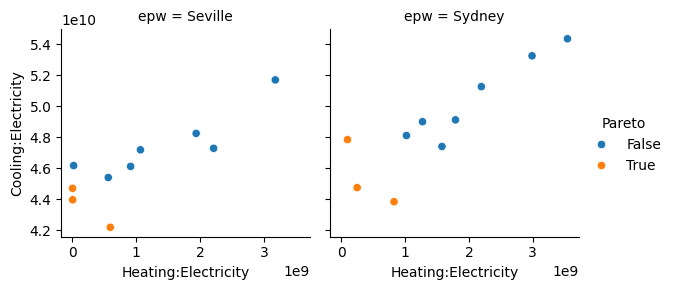

In [35]:
g = sns.FacetGrid(
    data=parametric.outputs_optimisation,
    col='epw'
)

g.map_dataframe(
    sns.scatterplot,
    x='Heating:Electricity',
    y='Cooling:Electricity',
    hue='pareto-optimal',
)
g.add_legend(title='Pareto')

We're done with the example, so let's remove all new files, so that we can re-run it again.

In [36]:
current_files = [i for i in listdir()]
new_files = set(current_files) - set(original_files)
new_files

{'available_outputs', 'notebook_temp_dir'}

In [37]:
import os
import shutil
for item in new_files:
    item_path = os.path.join(os.getcwd(), item)
    if os.path.isfile(item_path):
        os.remove(item_path)
    elif os.path.isdir(item_path):
        shutil.rmtree(item_path)